In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import os

# Afficher toutes les colonnes du dataframe;
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', 20)

In [2]:
# Lancement de Mlflow
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("projet_7")

<Experiment: artifact_location='mlflow-artifacts:/557530386428684495', creation_time=1713335388110, experiment_id='557530386428684495', last_update_time=1713335388110, lifecycle_stage='active', name='projet_7', tags={}>

### Prep

In [3]:
from gensim.models import Word2Vec, FastText
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization, LSTM, Layer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2
from keras.optimizers import Adam, RMSprop


2024-04-19 15:59:25.755393: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 15:59:25.852470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df = pd.read_csv('data/tweets_tokenized.csv')

In [5]:
X_full = df['dl']
y_full = df['label']

_, X, _, y = train_test_split(X_full, y_full, test_size=0.01, stratify=y_full, random_state=42)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [6]:
# Afficher l'évolution des performances lors de l'entrainement
def visualize_history(history):
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        plt.subplot(121)
        plt.plot(history.history['loss'], label='Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(122)
        plt.plot(history.history['accuracy'], label='Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

# modèle Kera LSTM + embedding Glove

In [58]:
# Préparation de l'embedding

# Charger le modèle d'embedding GloVe
embeddings_index = {}
with open('../Glove/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Préparer les datas pour keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_glove = tokenizer.texts_to_sequences(X_train)
X_val_glove = tokenizer.texts_to_sequences(X_val)
X_test_glove = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Normalisation de la taille des séquences
max_seq = max(len(seq) for seq in X_train_glove)
X_train_glove = pad_sequences(X_train_glove, maxlen=max_seq)
X_val_glove = pad_sequences(X_val_glove, maxlen=max_seq)
X_test_glove = pad_sequences(X_test_glove, maxlen=max_seq)

# Préparation de la matrice d'embedding
for word in embeddings_index:
    embedding_dim = len(embeddings_index[word])
    break

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Définir l'embedding
embedding_layer = Embedding(len(word_index) + 1, embedding_dim, trainable=False)
embedding_layer.build((None,))
embedding_layer.set_weights([embedding_matrix])

In [59]:
model_glove = Sequential()

# Ajouter les couches
model_glove.add(embedding_layer)
model_glove.add(LSTM(32))
model_glove.add(Dropout(0.5))
model_glove.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_glove.add(Dropout(0.5))
model_glove.add(BatchNormalization())
model_glove.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
# Entrainer le modèle

# Création du callback
model_save_path_glove = "./data/model_best_weights_glove.keras"
checkpoint = ModelCheckpoint(model_save_path_glove, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 32
epochs = 50

history_glove = model_glove.fit(
    X_train_glove, 
    y_train, 
    validation_data=(X_val_glove, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step - accuracy: 0.6564 - loss: 1.1210 - val_accuracy: 0.7811 - val_loss: 0.4985
Epoch 2/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.8269 - loss: 0.4447 - val_accuracy: 0.7677 - val_loss: 0.5264
Epoch 3/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.8998 - loss: 0.3057 - val_accuracy: 0.7739 - val_loss: 0.5622
Epoch 4/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.9231 - loss: 0.2487 - val_accuracy: 0.7702 - val_loss: 0.5910
Epoch 5/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9378 - loss: 0.2135 - val_accuracy: 0.7683 - val_loss: 0.6689
Epoch 6/50
2987/2987 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9456 - loss: 0.1896 - val_accuracy: 0.7621 - val_loss: 0.8815


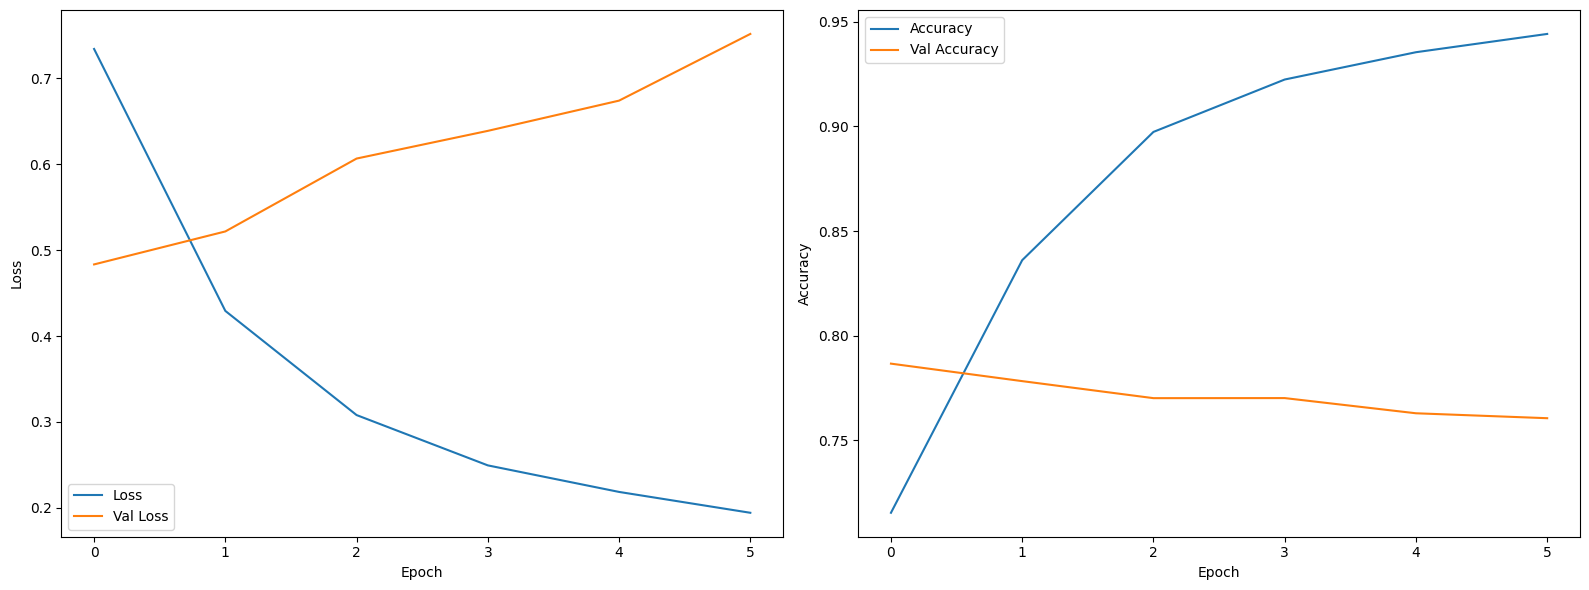

In [ ]:
visualize_history(history_glove)

In [ ]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_glove.evaluate(X_val_glove, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_glove.evaluate(X_test_glove, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.7606
Validation loss:  0.7519
Test Accuracy       :  0.7630
Test loss:  0.7397


In [ ]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_glove.load_weights(model_save_path_glove)

loss, accuracy = model_glove.evaluate(X_val_glove, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_glove.evaluate(X_test_glove, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.7867
Validation loss:  0.4834
Test Accuracy       :  0.7906
Test loss:  0.4782


In [29]:
# Enregistrer dans mlFlow

with mlflow.start_run(run_name="Simple Keras model with LSTM layer and glove 100 embedding"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_glove.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    signature = infer_signature(X_train_glove, model_glove.predict(X_train_glove))

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_glove,
        artifact_path="Keras_Glove_lstm",
        signature=signature,
        registered_model_name="Keras_Glove_lstm",
    )

2987/2987 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step


/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Keras_Glove_lstm'.
2024/04/18 09:04:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_Glove_lstm, version 1
Created version '1' of model 'Keras_Glove_lstm'.


# Modèle Keras LSTM et embedding USE

In [7]:
class USEEmbeddingLayer(Layer):
    # Chargement du module USE et définition de la dimension de sortie
    def __init__(self, **kwargs):
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
        # Use a test sentence to get the output dimension
        test_sentence = ["This is a test sentence."]
        self.dimensions = self.use(test_sentence).shape[1]
        super(USEEmbeddingLayer, self).__init__(**kwargs)

    # Initialisation des poids mais pas nécessaire ici
    def build(self, input_shape):
        super(USEEmbeddingLayer, self).build(input_shape)

    # Propagation avant. On utilise le module USE pour encoder les phrases
    def call(self, x, mask=None):
        result = self.use(tf.squeeze(tf.cast(x, tf.string)))
        return result
    # Définir la dimension de sortie
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [8]:
# Créer une instance de la couche USEEmbeddingLayer
use_layer = USEEmbeddingLayer()

# Ajouter les couches
model_use = tf.keras.models.Sequential()
model_use.add(tf.keras.layers.InputLayer(input_shape=(), dtype=tf.string))
model_use.add(use_layer)
model_use.add(tf.keras.layers.Reshape((1, 512)))
model_use.add(LSTM(32))
model_use.add(Dropout(0.5))
model_use.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model_use.add(Dropout(0.5))
model_use.add(BatchNormalization())
model_use.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_use.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-04-19 15:59:53.548338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 15:59:53.622911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 15:59:53.622952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 15:59:53.626158: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-19 15:59:53.626210: I external/local_xla/xla/stream_executor

In [9]:
# Entrainer le modèle

# Création du callback
model_save_path_use = "./data/model_best_weights_use.keras"
checkpoint = ModelCheckpoint(model_save_path_use, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)
callbacks_list = [checkpoint, es]

# Train the model
batch_size = 64
epochs = 50

history_use = model_use.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    batch_size=batch_size, 
    epochs=epochs, 
    callbacks=callbacks_list
    )

Epoch 1/50


2024-04-19 16:00:35.737111: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.6139 - loss: 2.1186 - val_accuracy: 0.8010 - val_loss: 1.2505
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7698 - loss: 0.9260 - val_accuracy: 0.7841 - val_loss: 0.7334
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.7766 - loss: 0.5551 - val_accuracy: 0.8136 - val_loss: 0.6138
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7947 - loss: 0.5137 - val_accuracy: 0.8085 - val_loss: 0.5166
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.7932 - loss: 0.5080 - val_accuracy: 0.8060 - val_loss: 0.4834
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7982 - loss: 0.4875 - val_accuracy: 0.8045 - val_loss: 0.4789
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8046 - loss: 0.4800 - val_accuracy: 0.8082 - val_loss: 0.4631
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.8028 - loss: 0.4762 - val_accura

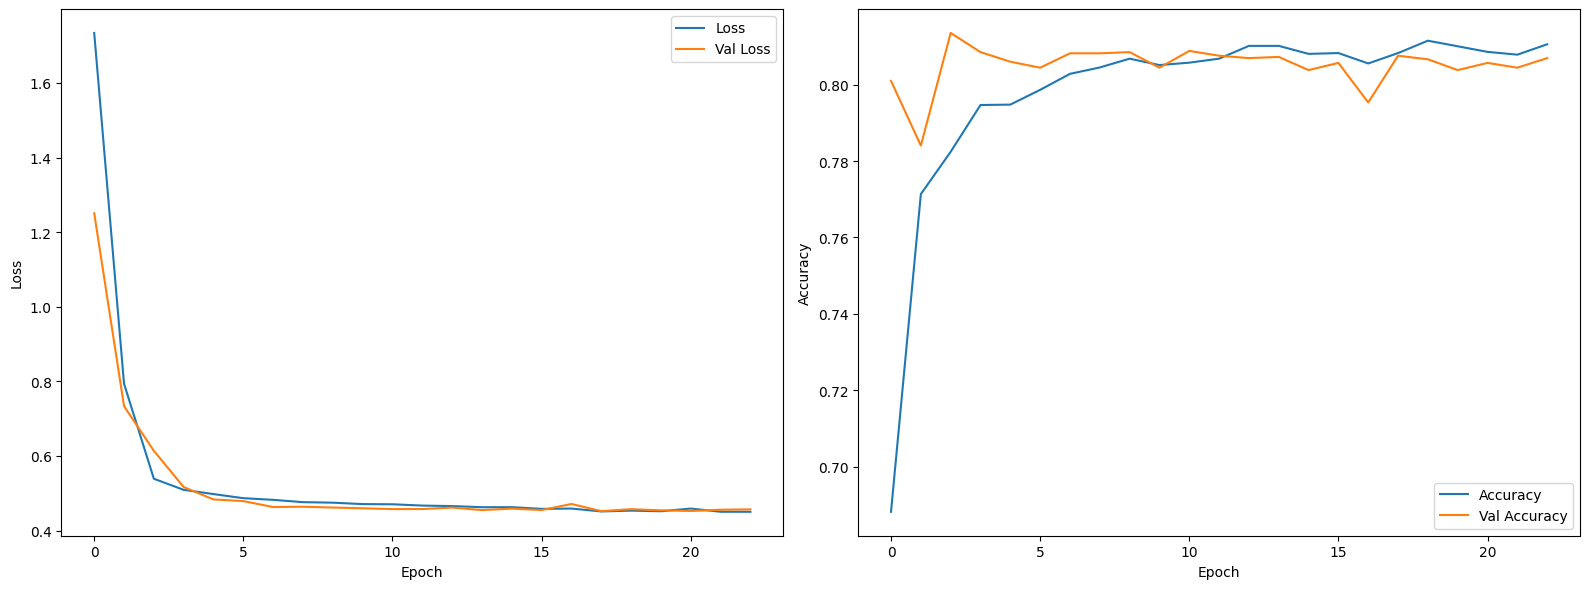

In [10]:
visualize_history(history_use)

In [11]:
# Prédire sur l'ensemble de test avec le dernier epoch

loss, accuracy = model_use.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

loss, accuracy = model_use.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

Validation Accuracy :  0.8067
Validation loss:  0.4563
Test Accuracy       :  0.8054
Test loss:  0.4531


In [12]:
# Prédire sur l'ensemble de test avec le meilleur epoch

model_use.load_weights(model_save_path_use)

loss, accuracy = model_use.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss:  {:.4f}".format(loss))

start_time = time.time()
loss, accuracy = model_use.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test loss:  {:.4f}".format(loss))

# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Validation Accuracy :  0.8076
Validation loss:  0.4516
Test Accuracy       :  0.8117
Test loss:  0.4473


In [50]:
# Enregistrer dans mlFlow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec


with mlflow.start_run(run_name="Keras model with LSTM layer and use embedding"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_use.get_config())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    input_schema = Schema([TensorSpec(type=np.dtype('float32'), shape=(-1,))])
    output_schema = Schema([TensorSpec(type=np.dtype('float32'), shape=(-1,))])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Enregistrement du modèle
    mlflow.keras.log_model(
        model=model_use,
        artifact_path="Keras_USE_lstm",
        signature=signature,
        registered_model_name="Keras_USE_lstm",
    )

2024/04/18 20:49:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmptljda9f5/model, flavor: keras). Fall back to return ['keras==3.0.5']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'Keras_USE_lstm'.
2024/04/18 20:49:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Keras_USE_lstm, version 1
Created version '1' of model 'Keras_USE_lstm'.


# Modèle bert bert-base-uncased

In [19]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import re

In [20]:
# Charger le modèle BERT pré-entraîné pour la classification de séquences
model_bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
# Charger le tokeniseur BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Définir où s'effectuera le calcule
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prétraitement

Special_tokens : 
* C'est une représentation d'une unité de texte. Cela peut être aussi simple qu'un mot ou aussi complexe qu'un sous-mot, selon le tokenizer utilisé.
    * CLS : jeton est toujours ajouté au début d'une séquence de texte.
    * SEP :jeton est utilisé pour marquer la fin d'une phrase ou la séparation entre deux phrases

Masques d'attention : 
* Les masques d'attention sont utilisés pour indiquer quels jetons sont des jetons de padding et quels jetons sont de vrais jetons, afin que le modèle ne tienne pas compte des jetons de padding lors du calcul de l'attention.

Tensor : 
* Classe qui offre de nombreuses opérations similaires à celles des matrices numpy, mais peut également être utilisée sur un GPU pour accélérer les calculs.

TensorDataset: 
* Utilisé pour emballer ensemble plusieurs tenseurs de données en un seul objet qui peut être utilisé comme un ensemble de données.

DataLoader: 
* Fournit des fonctionnalités telles que le chargement des données en mémoire par lots (batch), ce qui est essentiel lors de l'entraînement de modèles sur de grands ensembles de données, et le mélange des données (si shuffle=True est défini lors de l'initialisation du DataLoader). Il peut également effectuer des opérations en parallèle pour améliorer les performances, comme le chargement des données en utilisant plusieurs processus (si num_workers > 0 est défini lors de l'initialisation du DataLoader).
    * Shuffle = True : l'ordre des exemples d'entraînement change à chaque époque
    * num_workers > 0 : charger les données en utilisant plusieurs sous-processus

In [36]:
# Fonction de preprocessing du texte
def preprocess_text(text, max_length):
    # Nettoyage du texte
    text = re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)  # Supprimer les URL
    text = re.sub(r'@\w*', '', text)  # Supprimer les mentions
    text = re.sub(r'#', '', text)  # Supprimer les hashtags
    text = re.sub(r'\s+', ' ', text).strip()  # Supprimer les espaces excessifs

    # Tokenisation, conversion en identifiants de jetons et padding
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Ajouter les jetons spéciaux [CLS] et [SEP]
        max_length=max_length,  # Longueur maximale des séquences
        padding='max_length',  # Ajouter des padding
        return_attention_mask=True,  # Retourner les masques d'attention
        truncation=True  # Tronquer les séquences trop longues
    )

    return inputs['input_ids'], inputs['attention_mask']


# Fonction de création des tensors et dataloaders
def prepare_dataloader(X, y, preprocess_func, batch_size, max_length):
    inputs = [preprocess_func(tweet, max_length) for tweet in X] # Prétraiter les tweets
    input_ids = torch.tensor([i[0] for i in inputs]) # Créer un tensor pour les identifiants de jetons
    attention_masks = torch.tensor([i[1] for i in inputs]) # Créer un tensor pour les masques d'attention
    y_tensor = torch.tensor(y.values) # Créer un tensor pour les labels
    data = TensorDataset(input_ids, attention_masks, y_tensor)
    dataloader = DataLoader(data, batch_size=batch_size)
    return dataloader

In [37]:
batch_size = 128
max_length = max(len(sentence.split()) for sentence in X_train)

train_dataloader = prepare_dataloader(X_train, y_train, preprocess_text, batch_size, max_length)
val_dataloader = prepare_dataloader(X_val, y_val, preprocess_text, batch_size, max_length)
test_dataloader = prepare_dataloader(X_test, y_test, preprocess_text, batch_size, max_length)

In [14]:
'''
import gc
from torch import cuda

# Tester la taille de lot appropriée
batch_sizes = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
max_batch_size = None

for batch_size in batch_sizes:
    gc.collect()
    torch.cuda.empty_cache()
    try:
        outputs = None
        loss = None
        optimizer = AdamW(model.parameters(), lr=1e-5)

        # Créer un DataLoader avec la taille de lot actuelle
        train_data = TensorDataset(train_input_ids, train_attention_masks, y_train_tensor)
        dataloader = DataLoader(train_data, batch_size=batch_size)

        # Obtenir le premier lot
        inputs, masks, targets = next(iter(dataloader))

        # Déplacer le lot vers le GPU
        model_gpu = model.to(device)
        inputs = inputs.to(device)
        masks = masks.to(device)
        targets = targets.to(device)
        

        # Essayer d'effectuer une passe avant et arrière avec le lot
        optimizer.zero_grad()
        outputs = model_gpu(inputs, attention_mask=masks, labels=targets)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        print(f"Batch size {batch_size} fits in GPU memory")
        max_batch_size = batch_size

    except RuntimeError as e:
        if "out of memory" in str(e):
            print(f"Batch size {batch_size} doesn't fit in GPU memory")
            break
        else:
            raise e
    finally:
        # Supprimer les variables inutiles
        if inputs is not None: del inputs
        if masks is not None: del masks
        if targets is not None: del targets
        if outputs is not None: del outputs
        if loss is not None: del loss
        if model_gpu is not None: del model_gpu
        if optimizer is not None: del optimizer

        # Appeler le ramasse-miettes de Python
        gc.collect()
        torch.cuda.empty_cache()

print(f"The maximum batch size that fits in GPU memory is {max_batch_size}")
'''

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Utilisation du modèle

In [41]:
# Fonction d'entraînement et d'évaluation du modèle

def train_eval_model(model, dataloader, optimizer, scheduler, train=True):
    # Changer le mode du modèle en mode entraînement ou évaluation
    if train:
        model.train()
    else:
        model.eval()

    # Initialiser les variables pour le calcul de la perte et de l'exactitude
    loss_total = 0
    preds_list, true_list = [], []

    for batch in dataloader:

        input_ids, attention_mask, labels = batch

        # Déplacer les données vers le GPU
        model = model.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Réinitialiser les gradients si le mode est entraînement
        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            preds = torch.argmax(outputs.logits, dim=1)

        loss_total += loss.item()
        preds_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

        # Calculer les gradients et effectuer une étape d'optimisation si le mode est entraînement
        if train:
            loss.backward()
            optimizer.step()
            scheduler.step()
            
        # Mettre à jour la barre de progression avec la perte du lot actuel
        dataloader.set_postfix({'batch_loss': loss.item()}, refresh=True)
        dataloader.update()

        # Supprimer les variables pour libérer la mémoire du GPU
        del input_ids, attention_mask, labels, outputs, loss, preds
        torch.cuda.empty_cache()

    # Calculer la perte moyenne et l'exactitude
    avg_loss = loss_total / len(dataloader)
    acc = accuracy_score(true_list, preds_list)

    return avg_loss, acc

In [26]:


# Initialiser le meilleur loss à l'infini
best_val_loss = float('inf')
# Définir le nombre d'époques sans amélioration avant d'arrêter
patience = 3
epochs_no_improve = 0

# Définir l'optimiseur et le scheduler
optimizer = AdamW(model_bert.parameters(), lr=1e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)

# Initialiser les listes pour stocker les losses et les accuracies
history_bert = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


# Entrainer le modèle
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')

    for phase, dataloader in [('train', train_dataloader), ('val', val_dataloader)]:
        progress = tqdm(dataloader, desc=phase, leave=False)
        loss, acc = train_eval_model(model_bert, progress, optimizer, scheduler, train=(phase=='train'))
        
        history_bert[f'{phase}_loss'].append(loss)
        history_bert[f'{phase}_acc'].append(acc)

        print(f'{phase} loss: {loss:.4f}, {phase} accuracy: {acc:.4f}')

        # Si la loss de validation est la meilleure jusqu'à présent, sauvegarder le modèle
        if phase == 'val':
            if loss < best_val_loss:
                model_bert.to('cpu')
                torch.save(model_bert.state_dict(), model_save_path)
                model_bert.to(device)
                best_val_loss = loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                # Si aucune amélioration après 'patience' époques, arrêter l'entraînement
                if epochs_no_improve == patience:
                    print('Early stopping!')
                    break

    # Déplacer le modèle vers la CPU et vider le cache du GPU après chaque époque
    model_bert.to('cpu')
    torch.cuda.empty_cache()

Epoch 1/50


Train loss: 0.5878, Train accuracy: 0.7025
Val loss: 0.4740, Val accuracy: 0.7828
Epoch 2/50


Train loss: 0.4355, Train accuracy: 0.8060
Val loss: 0.4441, Val accuracy: 0.7976
Epoch 3/50


Train loss: 0.3811, Train accuracy: 0.8391
Val loss: 0.4410, Val accuracy: 0.8001
Epoch 4/50


Train loss: 0.3291, Train accuracy: 0.8685
Val loss: 0.4565, Val accuracy: 0.8010
Epoch 5/50


Train loss: 0.2770, Train accuracy: 0.8968
Val loss: 0.4886, Val accuracy: 0.7976
Epoch 6/50


Train loss: 0.2313, Train accuracy: 0.9188
Val loss: 0.5258, Val accuracy: 0.7972
Early stopping!


In [30]:
# Charger les poids du meilleur modèle
model_bert.load_state_dict(torch.load(model_save_path))

# Tester le modèle sur l'ensemble de test
start_time = time.time()

test_progress = tqdm(test_dataloader, desc='Validation', leave=False)
test_loss, test_acc = train_eval_model(model, test_progress, optimizer, scheduler, train=False)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')
# Prédire les labels et enregistrer le temps de prédiction
prediction_time = time.time() - start_time
# Calculer le temps de prédiction par tweet
prediction_time_per_tweet = prediction_time / len(y_test)

Test loss: 0.4088, Test accuracy: 0.8220


In [34]:
# Enregistrer dans mlFlow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

with mlflow.start_run(run_name="Modèle distilbert"):

    # Enregistrement des paramètres du modèle
    mlflow.log_params(model_bert.config.to_dict())

    # Enregistrement des résultats
    mlflow.log_metric("accuracy", test_acc)
    mlflow.log_metric("total time", prediction_time)
    mlflow.log_metric("time per prediction", prediction_time_per_tweet)

    # Définir la signature du modèle
    input_schema = Schema([
        ColSpec("long", "input_ids"),
        ColSpec("long", "attention_mask"),
        ColSpec("long", "labels")
    ])
    output_schema = Schema([ColSpec("long", "class")])
    signature = ModelSignature(inputs=input_schema, outputs=output_schema)

    # Enregistrement du modèle
    mlflow.pytorch.log_model(
        pytorch_model=model_bert,
        artifact_path="Distilbert",
        signature=signature,
        registered_model_name="distilbert",
    )

/usr/local/lib/python3.11/dist-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'distilbert'.
2024/04/19 14:32:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: distilbert, version 1
Created version '1' of model 'distilbert'.
